In [1]:
import qstock
import numpy as np
import pandas as pd

# 510300：沪深300ETF，代表大盘
# 510500：中证500ETF，代表小盘
# 510880：红利ETF，代表价值
# 159915：创业板ETF，代表成长
pool_list = ['510300', '510500', '510880', '159915']
start_date = '20130729'
data = qstock.get_price(pool_list, start=start_date, freq='d', fqt=2).sort_index()
name_list = data.columns.tolist()
data.head(10)

,红利ETF,创业板ETF,沪深300ETF,中证500ETF
date,,,,
2013-07-29,1.808,1.124,2.254,0.962
2013-07-30,1.827,1.110,2.267,0.957
2013-07-31,1.832,1.122,2.272,0.963
2013-08-01,1.861,1.177,2.331,0.990
2013-08-02,1.856,1.169,2.327,0.992
2013-08-05,1.870,1.193,2.360,1.009
2013-08-06,1.879,1.196,2.375,1.019
2013-08-07,1.868,1.162,2.359,1.006
2013-08-08,1.862,1.171,2.360,1.008


In [2]:
# 动量长度
N = 20
for name in name_list:
    data['日收益率_'+name] = data[name] / data[name].shift(1) - 1.0
    data['涨幅_'+name] = data[name] / data[name].shift(N+1) - 1.0
data = data.dropna()
data[['涨幅_'+v for v in name_list]].head(10)

,涨幅_红利ETF,涨幅_创业板ETF,涨幅_沪深300ETF,涨幅_中证500ETF
date,,,,
2013-08-27,0.073009,0.093416,0.074534,0.086279
2013-08-28,0.056924,0.089189,0.063520,0.085684
2013-08-29,0.052948,0.075758,0.058099,0.078920
2013-08-30,0.036002,-0.005098,0.029601,0.038384
2013-09-02,0.040948,0.023952,0.032230,0.038306
2013-09-03,0.048128,0.017603,0.033051,0.040634
2013-09-04,0.042576,0.015886,0.026105,0.029441
2013-09-05,0.047645,0.074010,0.028826,0.048708
2013-09-06,0.058002,0.077711,0.034322,0.054563


In [3]:
data['信号'] = data[['涨幅_'+v for v in name_list]].idxmax(axis=1).str.replace('涨幅_', '')
# 今日的涨幅由昨日的持仓产生
data['信号'] = data['信号'].shift(1)
data = data.dropna()
data['轮动策略日收益率'] = data.apply(lambda x: x['日收益率_'+x['信号']], axis=1) 
# 第一天尾盘交易，当日涨幅不纳入
data.loc[data.index[0],'轮动策略日收益率'] = 0.0
data['轮动策略净值'] = (1.0 + data['轮动策略日收益率']).cumprod()
data[['涨幅_'+v for v in name_list]+['信号','轮动策略日收益率','轮动策略净值']].head(10)

,涨幅_红利ETF,涨幅_创业板ETF,涨幅_沪深300ETF,涨幅_中证500ETF,信号,轮动策略日收益率,轮动策略净值
date,,,,,,,
2013-08-28,0.056924,0.089189,0.063520,0.085684,创业板ETF,0.000000,1.000000
2013-08-29,0.052948,0.075758,0.058099,0.078920,创业板ETF,-0.001654,0.998346
2013-08-30,0.036002,-0.005098,0.029601,0.038384,中证500ETF,-0.010587,0.987776
2013-09-02,0.040948,0.023952,0.032230,0.038306,中证500ETF,0.001946,0.989698
2013-09-03,0.048128,0.017603,0.033051,0.040634,红利ETF,0.014493,1.004041
2013-09-04,0.042576,0.015886,0.026105,0.029441,红利ETF,-0.000510,1.003529
2013-09-05,0.047645,0.074010,0.028826,0.048708,红利ETF,-0.001021,1.002505
2013-09-06,0.058002,0.077711,0.034322,0.054563,创业板ETF,0.011218,1.013751
2013-09-09,0.116129,0.080965,0.067511,0.057256,创业板ETF,-0.005547,1.008128


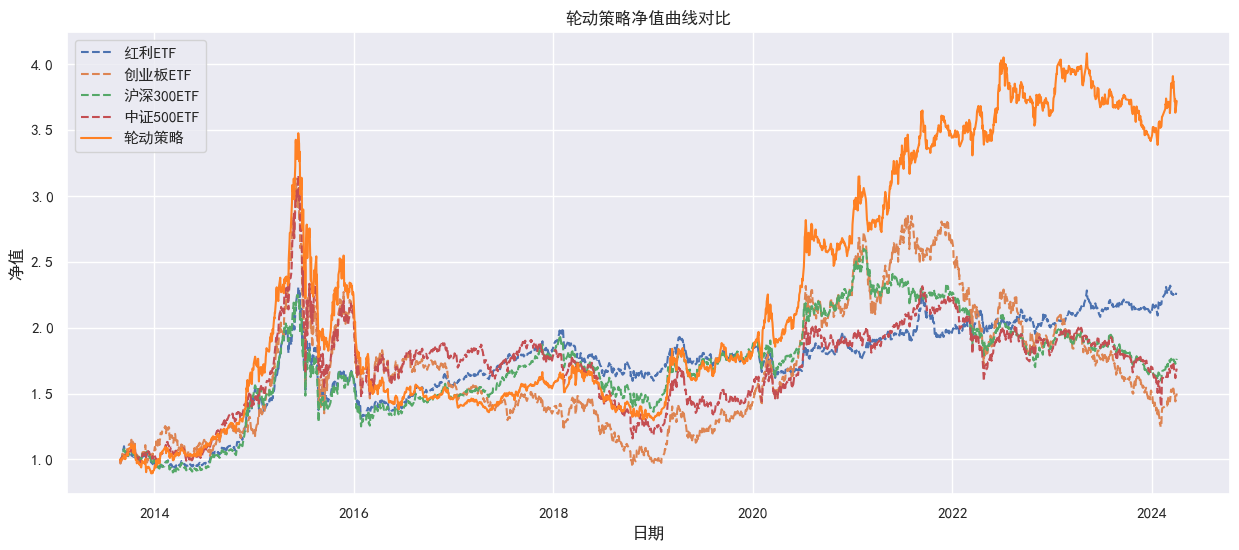

In [4]:
import matplotlib.pyplot as plt

plt.rcParams['axes.unicode_minus']=False

# 绘制净值曲线图
fig, ax = plt.subplots(figsize=(15, 6))
ax.set_xlabel('日期')
ax.set_ylabel('净值')
for name in name_list+['轮动策略']:
    if name in name_list:
        data[name+'净值'] = data[name]/data[name].iloc[0]
        ax.plot(data[name+'净值'].index, data[name+'净值'].values, linestyle='--')
    else:
        ax.plot(data[name+'净值'].index, data[name+'净值'].values, linestyle='-', color='#FF8124')

# 显示图例和标题
ax.legend(name_list+['轮动策略'])
ax.set_title('轮动策略净值曲线对比')

plt.show()

In [1]:
import quantstats as qstat

#将完整回测报告存为HTML文件
qstat.reports.html(data['轮动策略净值'], benchmark=data['沪深300ETF净值'],
                  title='轮动策略回测报告',
                  download_filename='轮动策略回测报告') 
#输出基本回测报告信息
qstat.reports.basic(data['轮动策略净值'], benchmark=data['沪深300ETF净值']) 

NameError: name 'data' is not defined